# Introduction

This notebook presents **lca-algebraic** a small libray above **brightay2**, designed for the definition of **parametric inventories** with fast computation of LCA impacts, suitable for **monte-carlo** analyis.

**lca-algebraic** provides a set of  **helper functions** for : 
* **compact** & **human readable** definition of activites :  
    * search background (tech and biosphere) activities 
    * create new foreground activites with parametrized amounts
    * parametrize / update existing background activities (extending the class **Activity**)
* Definition of parameters
* Computation of LCAs 
* Computation of statistics (including Sobols indices)
* Compute simplified parametric model by fixing minor input parameters

  
# Principles 

The main idea of this libray is to move from **procedural definition** of models (slow and prone to errors) to a **declarative / purely functionnal** definition of parametric models (models as **pure functions**). 

This enables **fast computation of LCA impacts**, useful for Monte Carlo methods and statistical analysis. 
We leverage the **power of symbolic calculus** provided by the library [SymPy](https://www.sympy.org/en/index.html).

We define our model in a **separate database**, as a nested combination of : 
* other foreground activities
* background activities :
    * Technical, refering **ecoinvent DB**
    * Biosphere, refering **brightway2** biosphere activities
    
The **amounts** in exchanges are expressed either as **static amounts**, or **symbolic expressions** of pre-defined **parameters**.

Each activity of our **root model** is defined as a **parametrized combination** of the **foreground activities**, which can themselves be expressed by the **background activities**.

When computing LCA for foreground models, the library develops the model as a combination of **only background activities**. It computes **once for all** the impact of **all required background activities** and compiles a **fast numpy** (vectorial) function for each impact, replacing each background activity by the **static value of the corresponding impact**.

By providing **large vectors** of **parameter values** to those numpy functions, we can compute LCA for **thousands of values** at a time.

![](https://oie-mines-paristech.github.io/lca_algebraic/doc/lca-algebraic.png)


# Compatiblity with brightway2 

Under the hood, the activities we define with **lca-algebraic** are standard **brightway2** activities. 
The amounts of exchanges are stored as **float values** or **serialized as string** in the property **formula**.

Parameters are also stored in the **brightay2** projets, making it fully compatible with **brightway**.

Thus, a model defined with **lca-algebraic** is stored as a regular **bw2** projet. We can use **bw2** native support for [parametrized dataset](https://2.docs.brightway.dev/intro.html#parameterized-datasets) for computing LCAs, even if much more slower than the method explain here.

# Doc

The followng notebook explores the main functions.
Full documentation of the functions is [available here](https://oie-mines-paristech.github.io/lca_algebraic/doc/)

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import brightway2 as bw

# Custom utils defined for inter-acv
from lca_algebraic import *
from lca_algebraic.stats import * 
import lca_algebraic
from sympy import init_printing, simplify

init_printing()

/home/rjolivet/anaconda3/envs/acv3.6/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Init brightway2 and databases

In [2]:
# Init the brightway2 project :choose any project name
initDb('MyProject')

# Import Ecoinvent DB (if not already done)
# Update the name and path to the location of the ecoinvent database
importDb("ecoinvent 3.4", './ecoinvent 3.4_cutoff_ecoSpold02/datasets')

# We use a separate DB for defining our foreground model / activities
# Choose any name
USER_DB = 'MyModelName'

# This is better to cleanup the whole foreground model each time, and redefine it in the notebook
# instead of relying on a state or previous run.
# Any persistent state is prone to errors.
resetDb(USER_DB)

# Parameters are stored at project level : reset them also
resetParams(USER_DB)

Biosphere database already present!!! No setup is needed


Database 'ecoinvent 3.4' has already been imported 
Db MyModelName was here. Reseting it


# Introduction to Numpy


Numpy is a python libray for symbolic calculus. 

You write Sympy expression as you write **standard python expressions**, using **sympy symbols** in them. 


The result is then a **symbolic expression that can be manipulated**, instead of a **numeric value**.

In [3]:
from sympy import symbols 

# create sympy symbol
a = symbols("a")

# Expressions are not directly evaluated 
f = a * 2 + 4 
f 

In [4]:
# symbols can be replaced by values afterwards 
f.subs(dict(a=3))

In practice, you don't need to care about Sympy. Just remember that : 
* The parameters defined below are **instances of sympy symbols**
* Any **valid python expression** containing a **sympy symbol** will create a **sympy symbolic expression**

# Define input parameters

First, we define the input parameters of the model together with their distribution.

The numeric parameters are **instances of sympy 'Symbol'**. 

Thus, any python arithmetic expression composed of parameters will result in a **symbolic expression** to be used later in the definition of the model, rather than a static numeric result.

In [5]:
# Example of 'float' parameters
a = newFloatParam(
    'a', 
    default=0.5, min=0, max=2,  distrib=DistributionType.TRIANGLE, # Distribution type, linear by default
    description="hello world")

b = newFloatParam(
    'b',
    default=0.5, # Fixed if no min /max provided
    description="foo bar")

share_recycled_aluminium = newFloatParam(
    'share_recycled_aluminium',  
    default=0.6, min=0, max=1, std=0.2, distrib=DistributionType.NORMAL, # Normal distrib, with std dev
    description="Share of reycled aluminium")

# You can define boolean parameters, taking only discrete values 0 or 1
bool_param = newBoolParam(
    'bool_param', 
    default=1)

# Example 'enum' parameter, acting like a switch between several possibilities
# Enum parameters are not Symbol themselves
# They are a facility to represent many boolean parameters at once '<paramName>_<enumValue>' 
# and should be used with the 'newSwitchAct' method 
elec_switch_param = newEnumParam(
    'elec_switch_param', 
    values=["us", "eu"], # If provided as list, all possibilities have te same probability
    default="us", 
    description="Switch on electricty mix")

# Another example enum param
techno_param = newEnumParam(
    'techno_param', 
    values={
        "technoA":0.4, 
        "technoB":0.1,
        "technoC":0.5}, # You can provide a statistical weight for each value, by using a dict
    default="technoA", 
    description="Choice of techonoly")

In [6]:
# List of parameters
list_parameters()

Phase,param,default,min,max,std,distrib,unit
,a,0.5,0,2,,triangle,
,b,0.5,,,,fixed,
,share recycled aluminium,0.6,0,1,0.2,normal,
,bool param,1,0,1,,linear,
,elec switch param,us,,,,linear,
,techno param,technoA,,,,linear,


# Get references to background activities

We provide two functions for easy and fast (indexed) search of activities in reference databases : 
* **findBioAct** : Search activity in **biosphere3** db
* **findTechAct** : Search activity in **ecoinvent** db

Those methods are **faster** and **safer** than using traditionnal "list-comprehension" search : 
They will **fail with an error** if **more than one activity** matches, preventing the model to be based on a random selection of one activity.


In [7]:
# Biosphere activities
ground_occupuation = findBioAct('Occupation, industrial area') # Search by name
heat = findBioAct('Heat, waste', categories=['air']) # Add category selector

# Technosphere activities

# You can add an optionnal location selector
alu = findTechAct("aluminium alloy production, AlMg3", loc="RER")
alu_scrap = findTechAct('aluminium scrap, new, Recycled Content cut-off')

# Elec 
eu_elec = findTechAct("market group for electricity, medium voltage", 'ENTSO-E')
us_elec = findTechAct("market group for electricity, medium voltage", 'US')

# Define the model

The model is defined as a nested combination of background activities with amounts.

Amounts are defined either as constant float values or algebric formulas implying the parameters defined above.

## Create new activities

In [8]:
# Create a new activity
activity1 = newActivity(USER_DB, # We define foreground activities in our own DB
    "first foreground activity", # Name of the activity
    "kg", # Unit
    exchanges= { # We define exhanges as a dictionarry of 'activity : amount'
        ground_occupuation:3 * b, # Amount can be a fixed value 
        heat: b + 0.2  # Amount can be a Sympy expression (any arithmetic expression of Parameters)
    })

# You can create a virtual "switch" activity combining several activities with a switch parameter
elec_mix = newSwitchAct(USER_DB, 
    "elect mix", # Name
    elec_switch_param, # Sith parameter
    { # Dictionnary of enum values / activities
        "us" : us_elec, # By default associated amount is 1
        "eu" : (eu_elec, 0.8)  # You can also provide custom amout or formula with a tuple 
    })

## Copy and update existing activity

You can copy and update an existing background activity.

Several new helper methods have been added to the class **Activity** for easy update of exchanges.

In [9]:
alu2 = copyActivity(
    USER_DB, # The copy of a background activity is done in our own DB, so that we can safely update it                
    alu, # Initial activity : won't be altered
    "Alu2") # New name

# Update exchanges by their name 
alu2.updateExchanges({
    
    # Update amount : the special symbol *old_amount* references the previous amount of this exchange
    "aluminium, cast alloy": old_amount * (1 - share_recycled_aluminium),
    
    # Update input activity. Note also that you can use '*' wildcard in exchange name
    "electricity*": elec_mix,
    
    # Update both input activity and amount. 
    # Note that you can use '#' for specifying the location of exchange (useful for duplicate exchange names)
    "chromium#GLO" : dict(amount=4.0, input=activity1)
}) 

# Add exchanges 
alu2.addExchanges({alu_scrap :  12})

## Final model

Usually, we normalize the final model as the whole LCI divided by the functional value (production of the system)


In [10]:
functional_value = a + 5

model = newActivity(USER_DB, "model", "kg", {
    activity1 : b * 5 + a + 1, # Reference the activity we just created
    alu2: 3 * share_recycled_aluminium, 
    alu:0.4 * a})

normalized_model = newActivity(USER_DB, "normalized model", "kg", {
    model : 1 / functional_value})

## Display activities

**printAct** displays the list of all exchanges of an activity.

Note that symbolic expressions have not been evaluated at this stage

In [11]:
# Print_act displays activities as tables
printAct(activity1) 
printAct(model)
printAct(normalized_model)

first foreground activity (1.000000 kg)  \
                                                                         input   
Heat, waste                          'Heat, waste' (megajoule, None, ('air',))   
Occupation, industrial area  'Occupation, industrial area' (square meter-ye...   

                                                                    
                              amount               unit       type  
Heat, waste                  b + 0.2          megajoule  biosphere  
Occupation, industrial area      3*b  square meter-year  biosphere

model (1.000000 kg)  \
                                                                                   input   
Alu2#RER {user-db}                                          'Alu2' (kilogram, RER, None)   
aluminium alloy production, AlMg3#RER  'aluminium alloy production, AlMg3' (kilogram,...   
first foreground activity {user-db}          'first foreground activity' (kg, GLO, None)   

                                                                             \
                                                           amount      unit   
Alu2#RER {user-db}                     3*share_recycled_aluminium  kilogram   
aluminium alloy production, AlMg3#RER                       0.4*a  kilogram   
first foreground activity {user-db}                   a + 5*b + 1        kg   

                                                     
                                               type  
Alu2#RER {user-db}                     technosphere  
aluminium alloy production, AlMg3#RER  technosphere  
first foreground activity {user-db}    technosphere

normalized model (1.000000 kg)                              
                                         input     amount unit          type
model {user-db}        'model' (kg, GLO, None)  1/(a + 5)   kg  technosphere

In [12]:
# You can also compute amounts by replacing parameters with a float value 
printAct(activity1, b=1.5) 

first foreground activity (1.000000 kg)  \
                                                                         input   
Heat, waste                          'Heat, waste' (megajoule, None, ('air',))   
Occupation, industrial area  'Occupation, industrial area' (square meter-ye...   

                                                                             
                                       amount               unit       type  
Heat, waste                  1.70000000000000          megajoule  biosphere  
Occupation, industrial area  4.50000000000000  square meter-year  biosphere

In [13]:
# You print several activities at once to compare them
printAct(alu, alu2)

# Select the impacts to consider

In [14]:
# List of impacts to consider
impacts = [m for m in bw.methods if 'ILCD 1.0.8 2016' in str(m) and 'no LT' in str(m)]


In [15]:
# You can provide alternate names for some methods
set_custom_impact_labels({
    impacts[0] : 'Resource usage',
    impacts[1]: 'Climate change'})

# Compute LCA

We provide two methods  for computing LCA : 
* **multiLCA** : It uses **brightway2** native parametric support. It is **much slower** and kept for **comparing results**.
* **multiLCAAlgebric** : It computes an algebric expression of the model and computes LCA once for all the background activities. Then it express each impact as a function of the parameters. This expression is then compiled into 'numpy' native code, for fast computation on vectors of samples. This version is 1 million time faster.

In [16]:
# Uses brightway2 parameters
multiLCA(
    normalized_model, 
    impacts, 
                   
    # Parameters of the model
    a=1, 
    b=2, 
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

,Resource usage,Climate change,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
normalized model,0.001918,1.313747,0.007555,1.172257,0.000092,3.406898e-07,0.001017,0.011743,5.694797e-08,0.04294,4.267009e-07,5.558090e-08,0.003601,0.001927,249.65113


In [17]:
# Compute with algebric implementation : the values should be the same
multiLCAAlgebric(
    normalized_model, # The model 
    impacts, # Impacts
    
    # Parameters of the model
    a=1, 
    b=2,
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

,Resource usage,Climate change,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
normalized model,0.001918,1.313747,0.007555,1.172257,0.000092,3.406898e-07,0.001017,0.011743,5.694796e-08,0.04294,4.267008e-07,5.558090e-08,0.003601,0.001927,35.421116


In [18]:
# You can compute several LCAs at a time and compare them:
multiLCAAlgebric(
    [alu, alu2], # The models
    
    impacts, # Impacts
    
    # Parameters of the model
    share_recycled_aluminium=0.3,
    elec_switch_param="us")

,Resource usage,Climate change,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
"aluminium alloy production, AlMg3[RER]",0.010063,5.731382,0.035596,5.890408,0.000352,0.000001,0.004777,0.054339,2.961301e-07,0.144029,0.000002,2.358739e-07,0.016481,0.007688,4.544623
Alu2[RER],0.007194,5.088309,0.028764,4.335949,0.000366,0.000001,0.003863,0.044837,2.035257e-07,0.172125,0.000002,2.138992e-07,0.013672,0.007482,92.712588


## Evaluate the contribution of a subset of activites to global impact

You can extract the contribution of a subset of activites to the global impact of the model

In [19]:
# Contribution of impact of aluminium
multiLCAAlgebric(
    normalized_model, # The model 
    impacts, # Impacts
    
    # List of sub activites to consider
    extract_activities = [alu, alu2],
    
    # Parameters of the model
    a=1, b=2, 
    elec_switch_param="us",
    share_recycled_aluminium=0.4)

,Resource usage,Climate change,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
normalized model,0.001918,1.313747,0.007555,1.172257,0.000092,3.406898e-07,0.001017,0.011743,5.694796e-08,0.04294,4.267008e-07,5.558090e-08,0.003601,0.001927,18.771116


## Fast computation of many parameter values

In [20]:
# Fast computation for millions of separate samples
multiLCAAlgebric(
    model, # The model 
    impacts, # Impacts
    
    # Parameters of the model
    a=list(range(1, 100000)), # All lists should have the same size
    share_recycled_aluminium=1, # Those parameters are fixed
    elec_switch_param="eu")

,Resource usage,Climate change,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
0,0.005511,6.999776,0.039485,5.628570,0.000565,0.000003,0.005364,0.069420,3.499349e-07,0.341596,0.000001,3.922766e-07,0.021970,0.014016,3.716098e+02
1,0.009536,9.292329,0.053724,7.984734,0.000706,0.000003,0.007275,0.091155,4.683870e-07,0.399208,0.000002,4.866262e-07,0.028563,0.017091,3.956277e+02
2,0.013561,11.584882,0.067962,10.340897,0.000847,0.000004,0.009186,0.112891,5.868390e-07,0.456819,0.000003,5.809757e-07,0.035155,0.020167,4.196455e+02
3,0.017586,13.877435,0.082200,12.697060,0.000988,0.000004,0.011096,0.134626,7.052910e-07,0.514431,0.000004,6.753253e-07,0.041748,0.023242,4.436634e+02
4,0.021612,16.169988,0.096439,15.053223,0.001129,0.000005,0.013007,0.156362,8.237431e-07,0.572043,0.000005,7.696748e-07,0.048340,0.026318,4.676812e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,402.507202,229248.525310,1423.796676,235607.816832,14.083766,0.048157,191.055409,2173.484699,1.184484e-02,5761.164185,0.086789,9.434782e-03,659.233962,307.530314,2.402012e+06
99995,402.511228,229250.817863,1423.810914,235610.172995,14.083907,0.048157,191.057320,2173.506435,1.184496e-02,5761.221796,0.086790,9.434876e-03,659.240554,307.533390,2.402036e+06
99996,402.515253,229253.110416,1423.825153,235612.529159,14.084047,0.048158,191.059230,2173.528170,1.184508e-02,5761.279408,0.086791,9.434970e-03,659.247147,307.536465,2.402060e+06
99997,402.519278,229255.402968,1423.839391,235614.885322,14.084188,0.048158,191.061141,2173.549906,1.184520e-02,5761.337020,0.086792,9.435065e-03,659.253739,307.539540,2.402085e+06


 # Statistic functions
 
 ## One at a time 
 
 We provide several functions for computing **statistics** for **local variations** of parameters (one at a time).
 
 ### oat_matrix(model, impacts)
 
 Shows a **matrix of impacts x parameters** colored according to the variation of the impact in the bounds of the parameter.

 


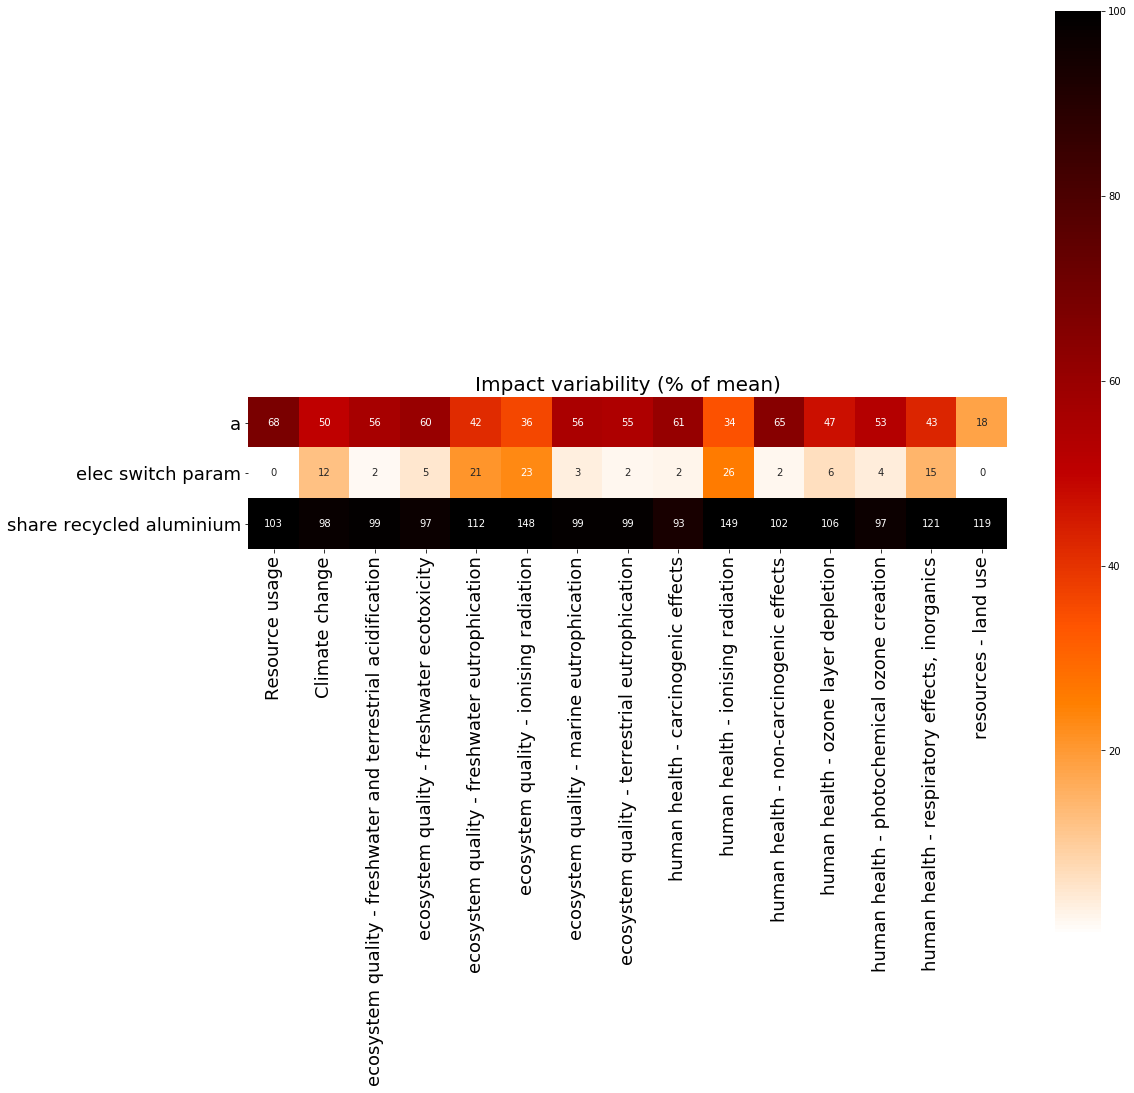

In [21]:
oat_matrix(model, impacts)

### oat_dashboard_matrix

This functions draws a dashboard showing :
* A dropdown list, for choosing a parameter
* Several graphs of evolution of impacts for this parameter
* Full table of data
* A graph of "bars" representing the variation of each impact for this parameter (similar to the information given in oat_matrix) 

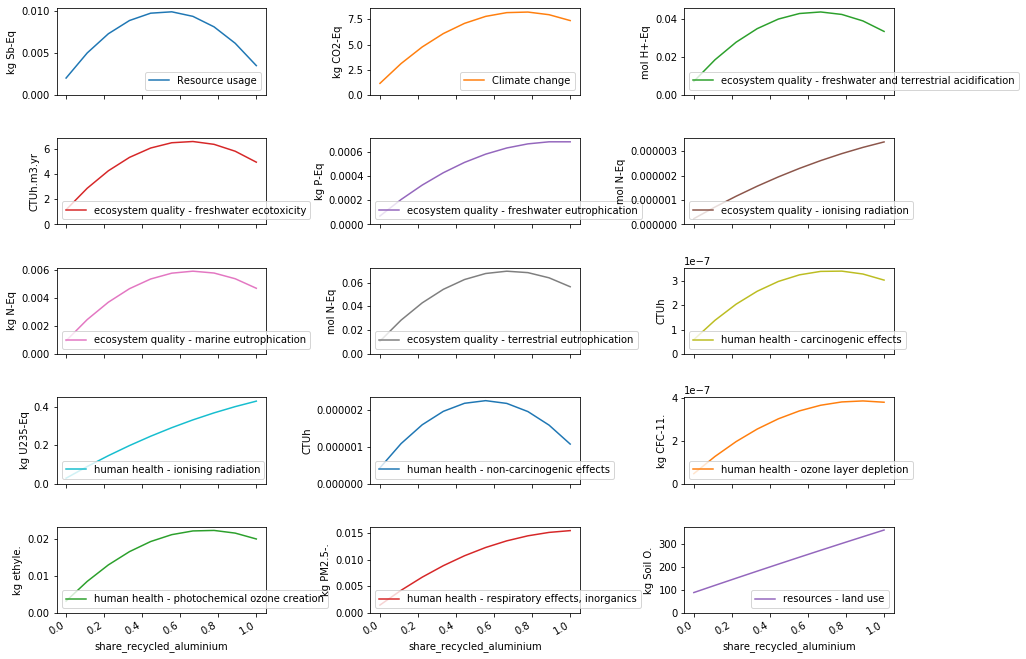

,Resource usage,Climate change,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
share_recycled_aluminium,,,,,,,,,,,,,,,
0.000000,0.002013,1.146276,0.007119,1.178082,0.000070,2.407838e-07,0.000955,0.010868,5.922602e-08,0.028806,4.339653e-07,4.717478e-08,0.003296,0.001538,89.708926
0.111111,0.005013,3.113141,0.018505,2.899258,0.000207,7.156209e-07,0.002478,0.028479,1.380839e-07,0.089603,1.095688e-06,1.276792e-07,0.008583,0.004289,120.847269
0.222222,0.007305,4.761463,0.027776,4.295893,0.000327,1.159081e-06,0.003724,0.042955,2.039818e-07,0.146374,1.609991e-06,1.973546e-07,0.013012,0.006737,151.710145
0.333333,0.008888,6.091240,0.034932,5.367987,0.000429,1.571165e-06,0.004695,0.054293,2.569198e-07,0.199119,1.976872e-06,2.562008e-07,0.016582,0.008884,182.297553
0.444444,0.009762,7.102474,0.039973,6.115538,0.000515,1.951873e-06,0.005389,0.062495,2.968978e-07,0.247840,2.196334e-06,3.042180e-07,0.019294,0.010728,212.609495
0.555556,0.009927,7.795165,0.042899,6.538548,0.000583,2.301204e-06,0.005808,0.067561,3.239158e-07,0.292534,2.268375e-06,3.414060e-07,0.021149,0.012270,242.645969
0.666667,0.009383,8.169312,0.043710,6.637017,0.000634,2.619158e-06,0.005951,0.069490,3.379738e-07,0.333204,2.192995e-06,3.677649e-07,0.022145,0.013510,272.406975
0.777778,0.008131,8.224915,0.042407,6.410943,0.000668,2.905736e-06,0.005818,0.068283,3.390720e-07,0.369847,1.970195e-06,3.832948e-07,0.022282,0.014447,301.892515
0.888889,0.006169,7.961974,0.038989,5.860328,0.000685,3.160938e-06,0.005409,0.063939,3.272101e-07,0.402466,1.599975e-06,3.879955e-07,0.021562,0.015083,331.102587


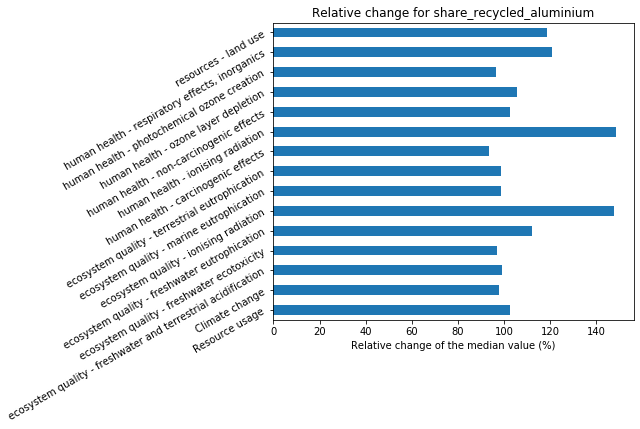

In [22]:
oat_dashboard_interact(
    model, impacts, 
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True)

## Monte-carlo methods & Sobol indices

Here we leverage fast computation of monte-carlo approches. 

We compute **global sensivity analysis** (GSA).
Not only local ones.


### Sobol Matrix 

Similar to OAT matrix, we compute Sobol indices. they represent the ratio between the variance due to a given parameter and the total variance.

for easier comparison, we translate those relative sobol indices into "deviation / mean" importance :

$$RelativeDeviation = \frac{\sqrt{sobol(param) \times totalVariance(impact))}}{mean(impact)}$$




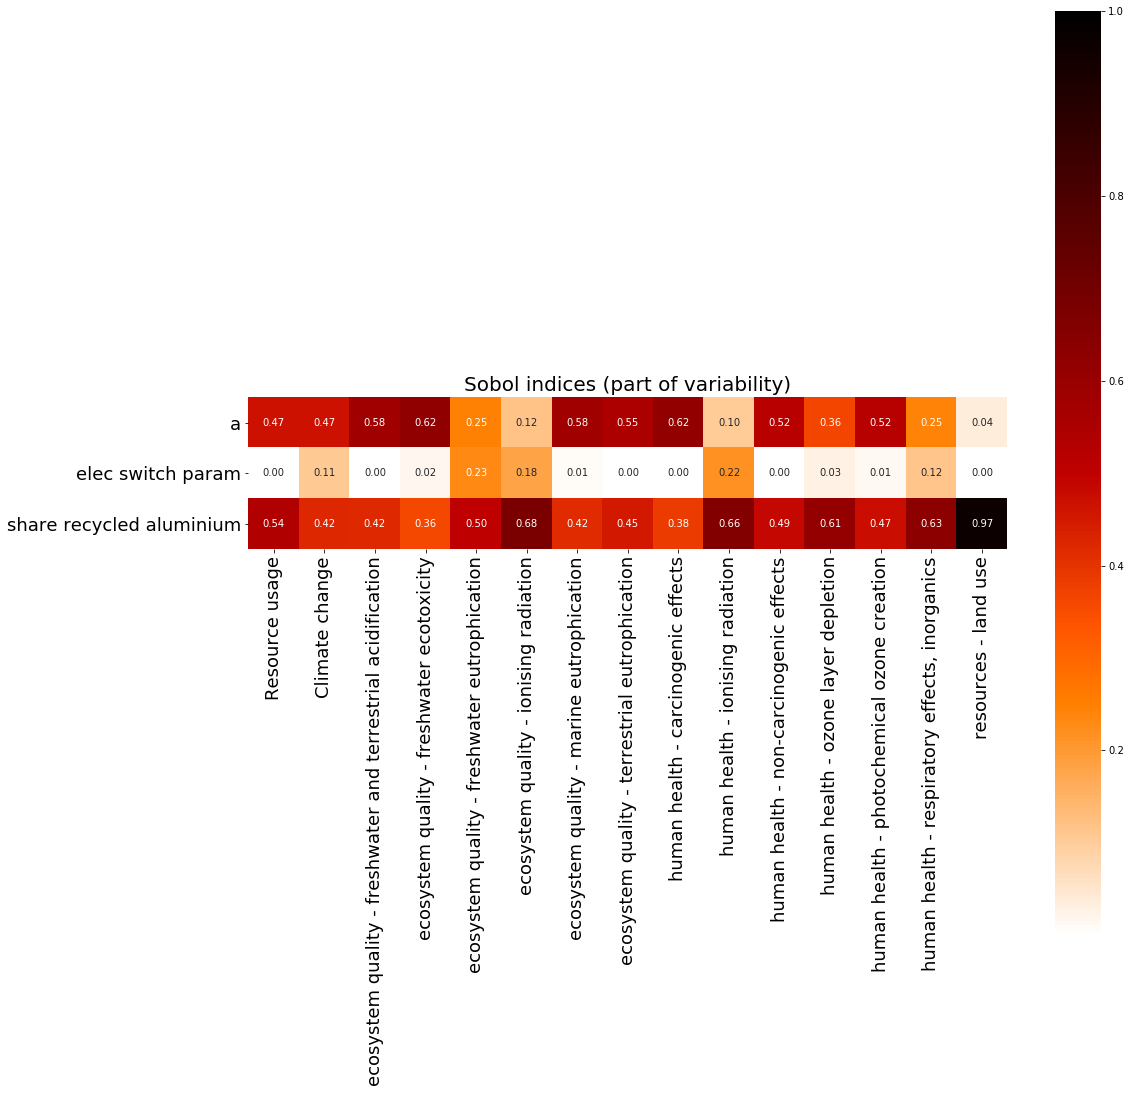

In [23]:
# Show sobol indices 
incer_stochastic_matrix(model, impacts)

###  Graphs of impacts and their distribution

We provide a dashboard showing **violin graphs** : the exact probabilistic distribution for each impact. Together with medians of the impacts.

Generating samples ...
Transforming samples ...


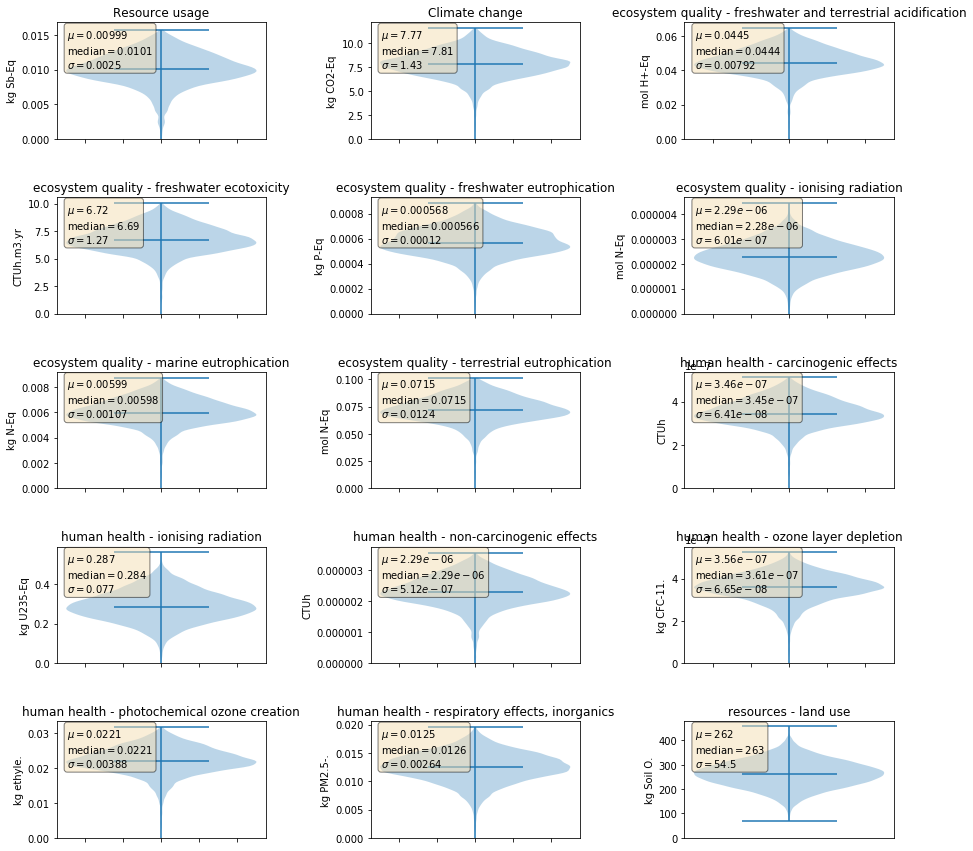

In [24]:
incer_stochastic_violin(
    model, impacts,
    
    # Optionnal layout parameters
    figspace=(0.5,0.5),
    figsize=(15, 15),
    sharex=True, 
    nb_cols=3)

Generating samples ...


Transforming samples ...


,Resource usage [kg Sb-Eq / kWh],Climate change [kg CO2-Eq / kWh],ecosystem quality - freshwater and terrestrial acidification [mol H+-Eq / kWh],ecosystem quality - freshwater ecotoxicity [CTUh.m3.yr / kWh],ecosystem quality - freshwater eutrophication [kg P-Eq / kWh],ecosystem quality - ionising radiation [mol N-Eq / kWh],ecosystem quality - marine eutrophication [kg N-Eq / kWh],ecosystem quality - terrestrial eutrophication [mol N-Eq / kWh],human health - carcinogenic effects [CTUh / kWh],human health - ionising radiation [kg U235-Eq / kWh],human health - non-carcinogenic effects [CTUh / kWh],human health - ozone layer depletion [kg CFC-11. / kWh],human health - photochemical ozone creation [kg ethyle. / kWh],"human health - respiratory effects, inorganics [kg PM2.5-. / kWh]",resources - land use [kg Soil O. / kWh]
median,0.0100704,7.80902,0.0443785,6.6832,0.000567022,2.27997e-06,0.00598306,0.0715089,3.44529e-07,0.284166,2.2937e-06,3.61016e-07,0.0221168,0.012565,262.457
std,0.00250313,1.43078,0.00794297,1.27051,0.000120619,6.01636e-07,0.00106892,0.0124583,6.42401e-08,0.0770646,5.12843e-07,6.66927e-08,0.00389517,0.00264935,54.5344
p,"[0.005675253187537826, 0.013775516795605815]","[5.4095717183898335, 10.023948947590709]","[0.031472064581685485, 0.05720796079054783]","[4.678777936432474, 8.79627213843899]","[0.00036872534553628706, 0.0007611914453233244]","[1.3021004005927333e-06, 3.2998530350445755e-06]","[0.004247584966884488, 0.007705344914951923]","[0.05084597200342536, 0.0911912629877231]","[2.416094774922341e-07, 4.5108624803444676e-07]","[0.16211846785569833, 0.41817680195072693]","[1.4199138683522792e-06, 3.0846080106035158e-06]","[2.37389417387899e-07, 4.5554893602989474e-07]","[0.015483453035645262, 0.02816409550606369]","[0.007852795272379294, 0.016526616314402262]","[171.8157310120806, 350.9224810476535]"
mean,0.0099879,7.77302,0.0444708,6.71614,0.000567667,2.28795e-06,0.00599371,0.0715008,3.46074e-07,0.28647,2.28731e-06,3.56116e-07,0.022064,0.0124561,261.996
var,0.250616,0.18407,0.178611,0.189173,0.212482,0.262958,0.178341,0.174239,0.185625,0.269015,0.224212,0.187278,0.176539,0.212695,0.20815


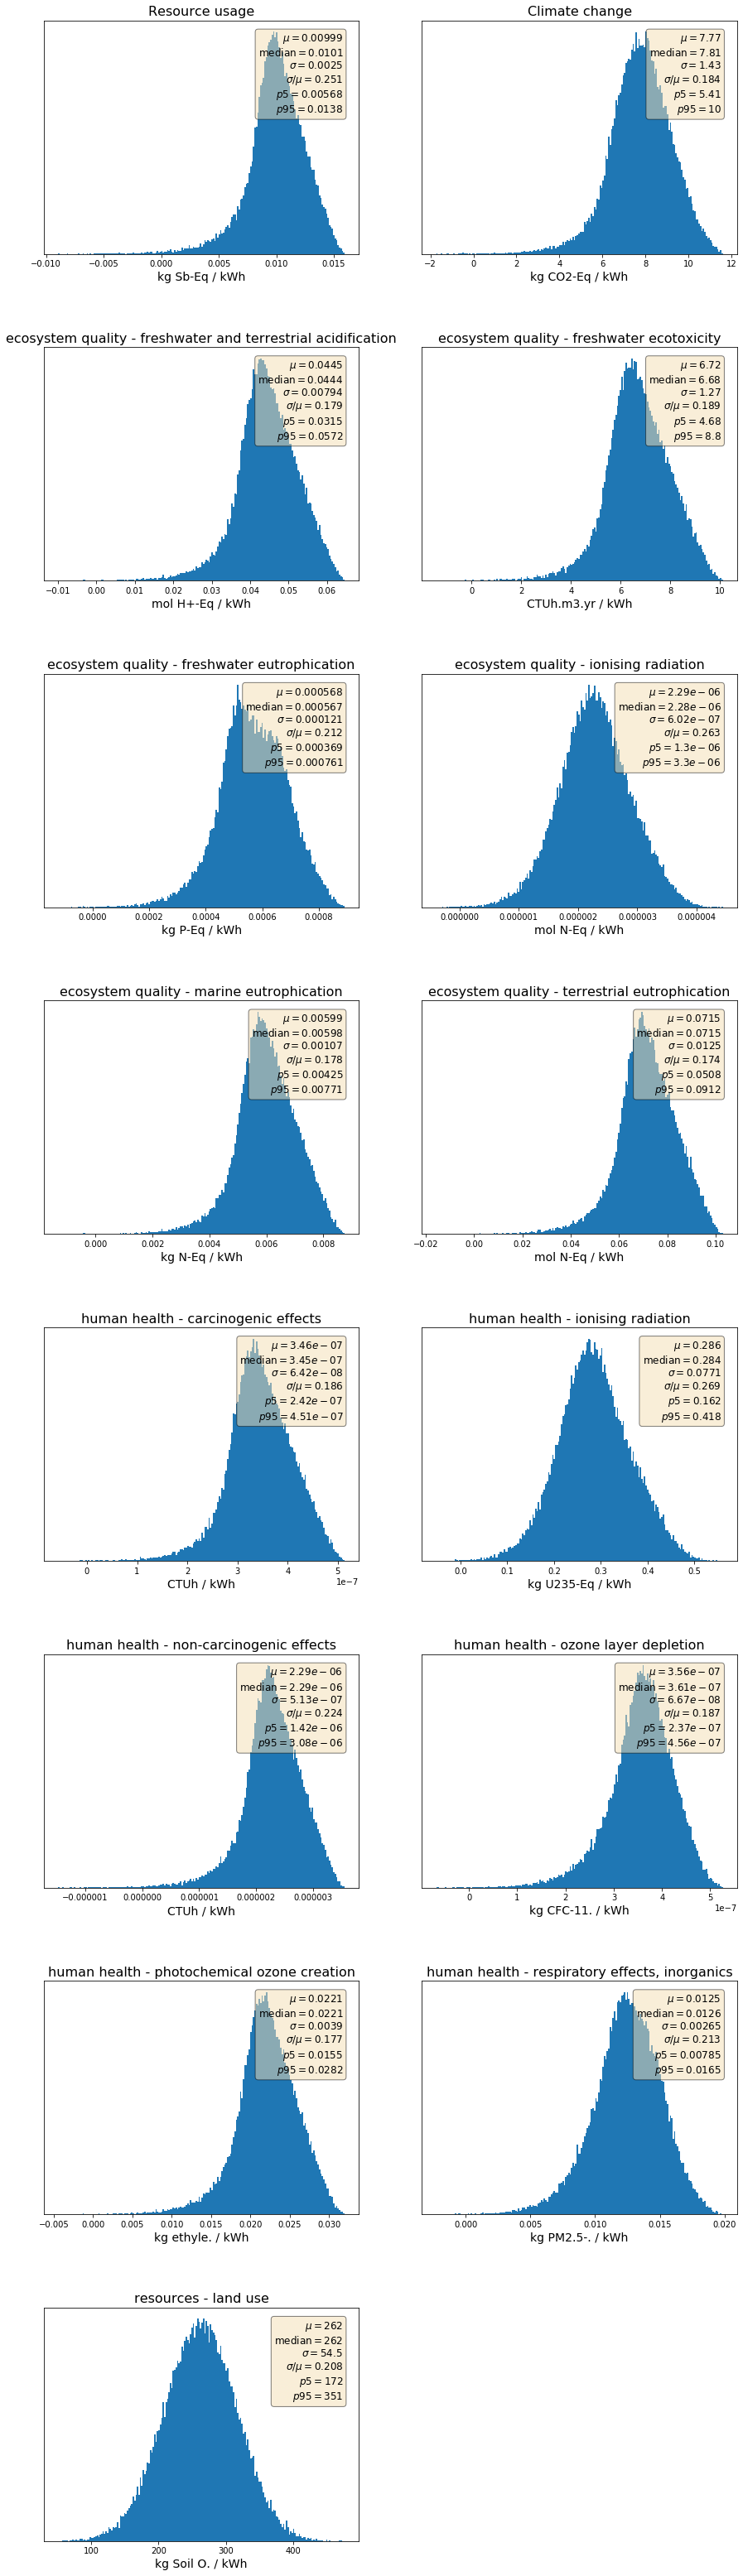

In [25]:
##### Alternatively, graphs can be shown horizontally, together with a box of statistical outcomes
graphs(
    model, impacts,
    
    # Optionnal layout parameters
    height=7, width=15,
    nb_cols=2,
    percentiles=[5, 95])

### Full dashboard

A dashboard groups all this information in a single interface with tabs.

It also shows total variation of impacts. This last graph could be improved by showing stacked colored bars with the contribution of each parameter to this variation, according to Sobol indices. 

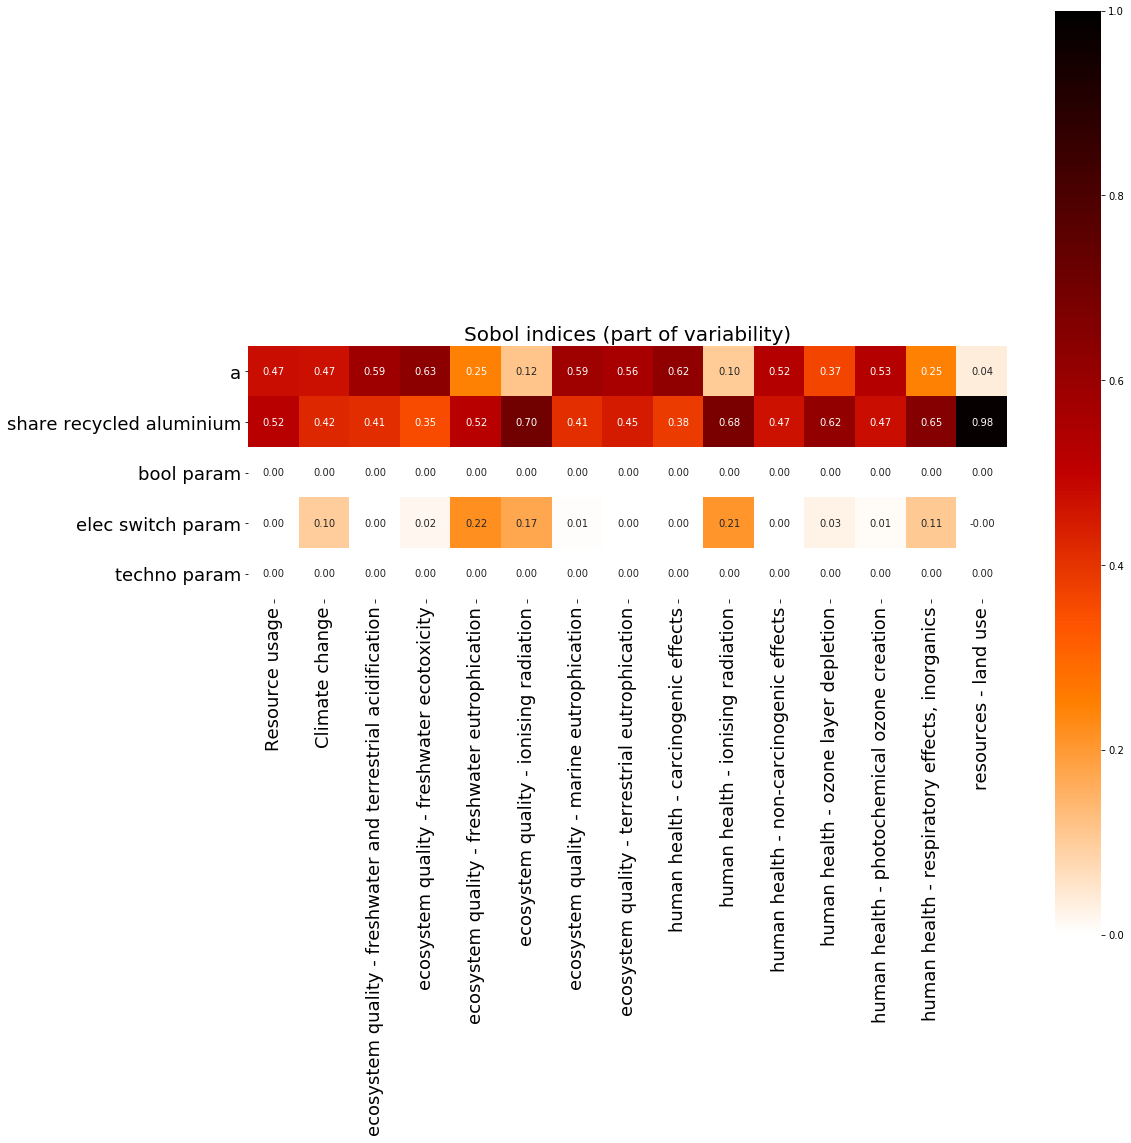

,Resource usage,Climate change,ecosystem quality - freshwater and terrestrial acidification,ecosystem quality - freshwater ecotoxicity,ecosystem quality - freshwater eutrophication,ecosystem quality - ionising radiation,ecosystem quality - marine eutrophication,ecosystem quality - terrestrial eutrophication,human health - carcinogenic effects,human health - ionising radiation,human health - non-carcinogenic effects,human health - ozone layer depletion,human health - photochemical ozone creation,"human health - respiratory effects, inorganics",resources - land use
mean,9.988571e-03,7.774097,0.044476,6.716877,0.000568,2.288409e-06,0.005994,0.071509,3.461153e-07,0.286529,2.287497e-06,3.561677e-07,0.022067,0.012458,262.031632
std,2.498024e-03,1.427738,0.007919,1.267415,0.000120,6.007778e-07,0.001066,0.012416,6.407895e-08,0.076955,5.116959e-07,6.653898e-08,0.003884,0.002645,54.496813
p10,7.119199e-03,6.075600,0.035317,5.273576,0.000420,1.536784e-06,0.004764,0.057174,2.700937e-07,0.191432,1.701418e-06,2.725954e-07,0.017449,0.009114,192.718788
p90,1.301057e-02,9.572394,0.054594,8.360668,0.000720,3.073650e-06,0.007359,0.087412,4.296803e-07,0.389018,2.923849e-06,4.354020e-07,0.026936,0.015652,331.245770
p25,8.675564e-03,6.915973,0.039818,5.934694,0.000491,1.895818e-06,0.005367,0.064537,3.070144e-07,0.235662,2.007377e-06,3.213231e-07,0.019975,0.010908,225.360008
p50,1.008036e-02,7.812982,0.044417,6.688302,0.000566,2.280387e-06,0.005984,0.071528,3.445791e-07,0.284217,2.294795e-06,3.606859e-07,0.022095,0.012578,262.770449
p75,1.162878e-02,8.724762,0.049691,7.569082,0.000653,2.684449e-06,0.006706,0.079739,3.885236e-07,0.336828,2.625154e-06,4.000634e-07,0.024596,0.014247,299.114465
Sobol 1(a),4.727186e-01,0.468821,0.589689,0.629445,0.248115,1.167709e-01,0.585814,0.559741,6.230170e-01,0.101712,5.239231e-01,3.668402e-01,0.525333,0.246144,0.036316
Sobol 1(share_recycled_aluminium),5.191008e-01,0.423525,0.411931,0.353045,0.516290,7.040847e-01,0.409667,0.445862,3.836315e-01,0.680684,4.670368e-01,6.202405e-01,0.474388,0.649015,0.981810
Sobol 1(bool_param),0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000


In [26]:
incer_stochastic_dashboard(model, impacts)

# Producing simplified models 

One of te outcome of the statisticall analysis above would be to identify main input parameters and produce simplidied models, fixing the minor ones.

We provide several functions for doing this.

## Explore initial algrebraic model

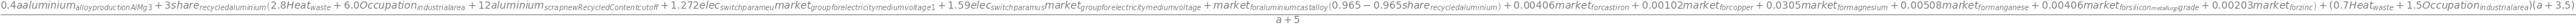

In [27]:
# First, let's look at the full expression defining our model
expr, _ = actToExpression(normalized_model)
expr

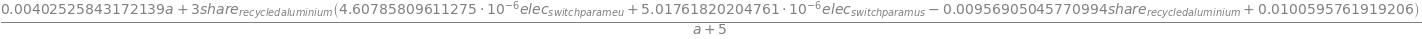

In [28]:
# For each impact, this expression is developped by replacing background activities with their impact value
# Here is an internal method used by #LCAAlgebraic 
lambdas = preMultiLCAAlgebric(normalized_model, impacts)

# "lamddas" wrap the expression together with list of required parameters and a 
# compiled (lambidfy) version of it, ready for fast compuation 

# Here is for example the algebraic expression for the first impact
lambdas[0].expr

## Compute simplified models

We provide some method to automatically select a subset of parameters, based on the **sobol indices**, and then compute simplified models for it.

We also round numerical expression to 3 digits, and we remove terms in sums that are less than 1% of total.

In [29]:
simplified = sobol_simplify_model(
    normalized_model, # The model
    impacts, # Impacts to consider
    n=10000, # For large model, you may test other value and ensure ST and sum(S1) are close to 1.0 
    fixed_mode = FixedParamMode.MEDIAN, # We replace minor parameters by median by default,
    min_ratio=0.8, # Min ratio of variability to explain

    num_digits=3)

Generating samples ...


Transforming samples ...


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'resources', 'mineral, fossils and renewables')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'climate change', 'GWP 100a')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater and terrestrial acidification')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater ecotoxicity')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'freshwater eutrophication')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'ionising radiation')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'marine eutrophication')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'ecosystem quality', 'terrestrial eutrophication')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'human health', 'carcinogenic effects')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'human health', 'ionising radiation')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'human health', 'non-carcinogenic effects')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'human health', 'ozone layer depletion')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'human health', 'photochemical ozone creation')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'human health', 'respiratory effects, inorganics')


Processing sobol for ('ILCD 1.0.8 2016 midpoint no LT (obsolete)', 'resources', 'land use')


> Method :  Resource usage
S1:  1.0004029764922717
S2:  -0.01692740301200257
ST:  1.0043867011450378
Selected params :  ['share_recycled_aluminium', 'a'] explains:  1.0004029828598962


(0.00403*a - 3*share_recycled_aluminium*(0.00957*share_recycled_aluminium - 0.0101))/(a + 5)
> Method :  Climate change
S1:  0.9744342225253507
S2:  0.039179583070578616
ST:  1.0215331863415167
Selected params :  ['share_recycled_aluminium', 'elec_switch_param'] explains:  0.8480836348258377


0.519*share_recycled_aluminium*(0.545*elec_switch_param_eu + 1.05*elec_switch_param_us - 4.3*share_recycled_aluminium + 5.32) + 0.311
> Method :  ecosystem quality - freshwater and terrestrial acidification
S1:  0.9935256974999263
S2:  0.014768754657660817
ST:  1.0029368578987186
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9904118835630494


(0.0142*a - 3*share_recycled_aluminium*(0.0285*share_recycled_aluminium - 0.0371))/(a + 5)
> Method :  ecosystem quality - freshwater ecotoxicity
S1:  0.9919893291943871
S2:  0.01140603135549514
ST:  1.0054156556200609
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9623430084242794


(2.36*a - 3*share_recycled_aluminium*(4.38*share_recycled_aluminium - 5.56))/(a + 5)
> Method :  ecosystem quality - freshwater eutrophication
S1:  0.9618688223505146
S2:  0.05033180431868803
ST:  1.0366745282208139
Selected params :  ['share_recycled_aluminium', 'elec_switch_param'] explains:  0.9329589443598921


0.52*share_recycled_aluminium*(6.2e-5*elec_switch_param_eu + 0.000125*elec_switch_param_us - 0.000231*share_recycled_aluminium + 0.00031) + 1.88e-5
> Method :  ecosystem quality - ionising radiation
S1:  0.9736764536713443
S2:  0.032744433773562995
ST:  1.028315368900667
Selected params :  ['share_recycled_aluminium', 'elec_switch_param'] explains:  0.9693664900414903


0.52*share_recycled_aluminium*(6.74e-7*elec_switch_param_eu + 9.56e-7*elec_switch_param_us - 4.24e-7*share_recycled_aluminium + 5.15e-7) + 6.41e-8
> Method :  ecosystem quality - marine eutrophication
S1:  0.9919766139637056
S2:  0.017973281096503705
ST:  1.0041059344044905
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9776466726515102


(0.00191*a - 3*share_recycled_aluminium*(0.00372*share_recycled_aluminium - 0.00493))/(a + 5)
> Method :  ecosystem quality - terrestrial eutrophication
S1:  0.991940844205722
S2:  0.022140734850701033
ST:  1.00359335971827
Selected params :  ['share_recycled_aluminium'] explains:  0.8058753518000495


-0.519*share_recycled_aluminium*(0.0423*share_recycled_aluminium - 0.0579) + 0.00295
> Method :  human health - carcinogenic effects
S1:  0.9928322886363267
S2:  0.020538286092353843
ST:  1.0032095891919783
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.987288509214058


(1.18e-7*a - 3*share_recycled_aluminium*(1.75e-7*share_recycled_aluminium - 2.54e-7))/(a + 5)
> Method :  human health - ionising radiation
S1:  0.9697943214743554
S2:  0.03638309809758687
ST:  1.0321330512936613
Selected params :  ['share_recycled_aluminium', 'elec_switch_param'] explains:  0.9674285505879201


0.52*share_recycled_aluminium*(0.0833*elec_switch_param_eu + 0.123*elec_switch_param_us - 0.0543*share_recycled_aluminium + 0.0657) + 0.00765
> Method :  human health - non-carcinogenic effects
S1:  0.9990895332104638
S2:  -0.012169078496076811
ST:  1.0039789553013185
Selected params :  ['share_recycled_aluminium', 'a'] explains:  0.9968967083201474


(8.68e-7*a - 3*share_recycled_aluminium*(1.99e-6*share_recycled_aluminium - 2.2e-6))/(a + 5)
> Method :  human health - ozone layer depletion
S1:  0.9883289358633081
S2:  0.02911750705794791
ST:  1.0091040200916597
Selected params :  ['share_recycled_aluminium'] explains:  0.8854360618135323


-0.518*share_recycled_aluminium*(1.46e-7*share_recycled_aluminium - 2.52e-7) + 1.3e-8
> Method :  human health - photochemical ozone creation
S1:  0.9902911360250968
S2:  0.0268098954213102
ST:  1.0051763357992074
Selected params :  ['share_recycled_aluminium'] explains:  0.8159282803039338


-0.521*share_recycled_aluminium*(0.0116*share_recycled_aluminium - 0.0169) + 0.000865
> Method :  human health - respiratory effects, inorganics
S1:  0.978517384137115
S2:  0.033884908127784975
ST:  1.0210891064592342
Selected params :  ['share_recycled_aluminium'] explains:  0.8093451582712098


-0.518*share_recycled_aluminium*(0.00408*share_recycled_aluminium - 0.00822) + 0.000421
> Method :  resources - land use
S1:  0.996641654420644
S2:  0.00690112078601964
ST:  1.0066704765291115
Selected params :  ['share_recycled_aluminium'] explains:  0.9712924861896681


-0.519*share_recycled_aluminium*(3.72*share_recycled_aluminium - 93.8) + 16.7


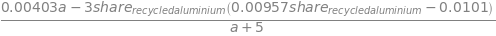

In [30]:
# Let's look at the expression for first impact again 
# much simpler ! 
simplified[0].expr

## Compare simplified model with full model

Finally, we can compare the distribution of those simplified model against the full model. We provide a function for graphical display of it, and compuation of de R-Square score.


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


Generating samples ...
Transforming samples ...


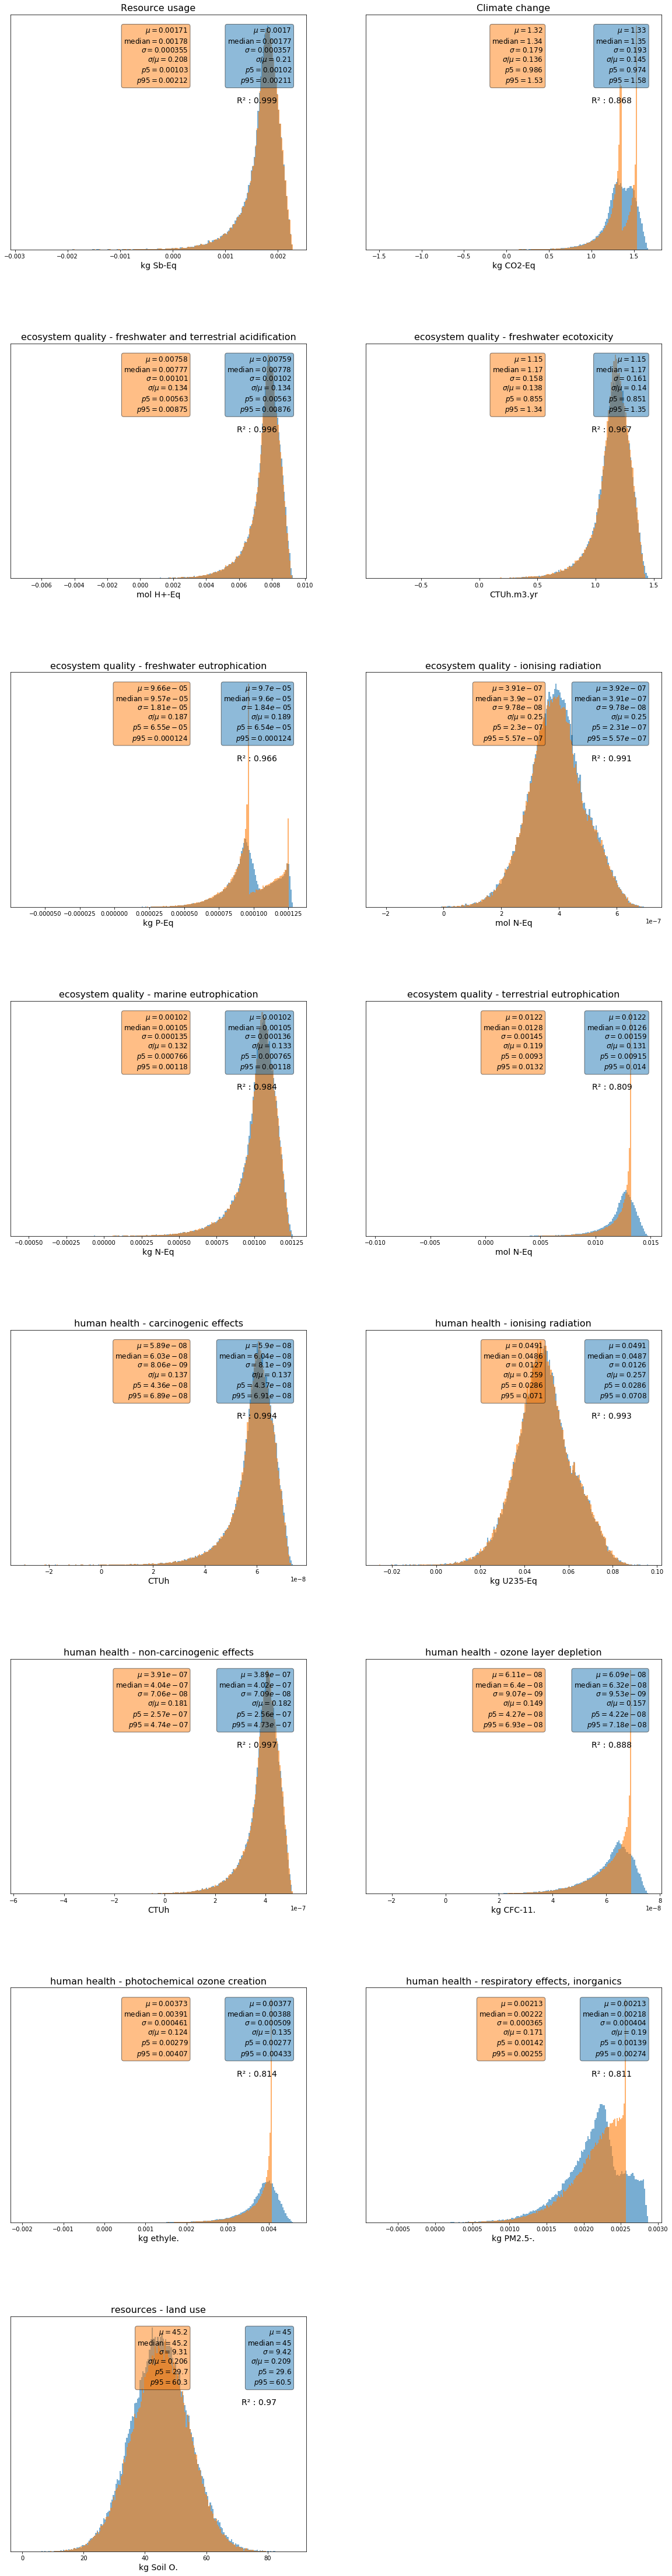

In [31]:
compare_simplified(normalized_model, impacts, simplified)